###  Tutorial notebook v1  
## <span style="color:midnightblue">Genes2Genes - A new algorithm and framework for single-cell Trajectory Alignment </span>
***To guide downstream comparative analysis of reference and query systems through a gene-level/cell-level alignment*** <br>
***<span style="color:blue">
(e.g. Organoid vs. Reference tissue, Healthy vs. Disease, Control vs. Treatment etc. along a pseudotime axis)
 </span>***

In this tutorial, we are going to analyse the differences between 2 different treatment groups of Dendritic cells, stimulated under 2 conditions: (1) PAM and (2) LPS (from Shalek et al (2014)). The single cell datasets were downloaded from https://github.com/shenorrLab/cellAlign (Alpert et al 2018) and packaged into adata objects. There are 2 gene sets (datasets) considered by (Alpert et al 2018) -- that have global similarities and local similarities, separately. They have also provided pseudotime estimates for all cells which will use to align.
<br><br>
**<span style="color:red">Note: This is the initial and testable version of Genes2Genes (still unpublished and under refinement) so you might run into unforseen errors and bugs. Please do let me know so that I can correct them before releasing the stable version. Thanks!</span>**


In [1]:
import anndata
import numpy as np
import pandas as pd
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
from tabulate import tabulate
import os,sys,inspect
# setting the path to source
sys.path.insert(0,os.path.dirname(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))) + '/source') 

# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import PathwayAnalyser

import warnings
warnings.filterwarnings("ignore")

### Load reference and query data 

**Input to Genes2Genes:** a reference adata object and a query adata object, each containing the pseudotime values in their obs variable named 'time'. 

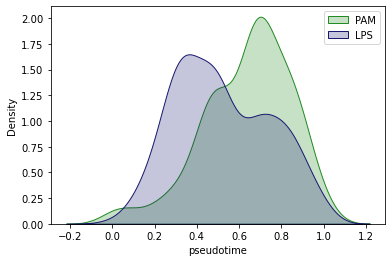

In [2]:
adata_ref = anndata.read_h5ad('/nfs/team205/ds40/OrgAlign/TutorialData/adata_pam_local.h5ad') # PAM
adata_query = anndata.read_h5ad('/nfs/team205/ds40/OrgAlign/TutorialData/adata_lps_local.h5ad') # LPS

## ---- to load datasets with global similarities --------
#adata_ref = anndata.read_h5ad('/nfs/team205/ds40/OrgAlign/TutorialData/adata_pam_global.h5ad') 
#adata_query = anndata.read_h5ad('/nfs/team205/ds40/OrgAlign/TutorialData/adata_lps_global.h5ad')

# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='PAM', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='LPS', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()

Define the list of genes you are interested in analysing (e.g. set of transcription factors, set of marker genes, a certain pathway related set of genes).  Here we use all genes in the dataset which have been specified as important to the context by  Alpert et al 2018. 

In [3]:
gene_list = adata_ref.var_names 
len(gene_list)

89

## <span style="color:midnightblue"> Gene-level alignment </span> 

### 1. Align a single gene of reference and query

Genes2Genes can find you an optimal alignment between the reference and query gene trajectories by matching or mismatching their respective time points based on corresponding levels of gene expression. It first interpolates the data to smoothen the trajectories. 
Example: align gene **NFKBIZ**

In [5]:
# Create a reference query aligner object
# Pass the reference adata, query adata, and the gene list to perform pairwise alignment
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, 40)
aligner.WEIGHT_BY_CELL_DENSITY = True

gene = 'NFKBIZ' # example gene for local dataset
#gene = 'TLR2'
# Run pairwise alignment between ref and query for the given gene
#al_obj = aligner.align_single_pair(gene, state_params=[0.95,0.4,0.4])
al_obj = aligner.align_single_pair(gene)


[<TimeSeriesPreprocessor.SummaryTimeSeries object at 0x7fcc086306d0>, <TimeSeriesPreprocessor.SummaryTimeSeries object at 0x7fcc08630d60>] NFKBIZ


0123456789012345678901234567890123456789012345678901234567 Alignment index 
   0123456789012345678901234567890000000000000000001234567 Reference index
---*******************************^^^^^^^^^^^^^^^^^*******
***--------------------***********************************
012                    34567890123456789012345678901234567 Query index
IIIDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMVVVVVVVVVVVVVVVVVMMMMMMM 5-state string 


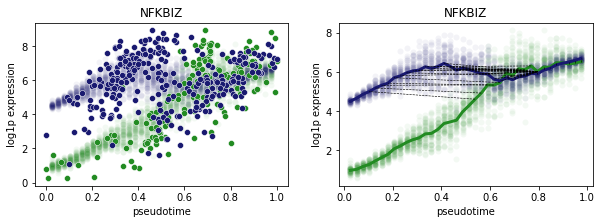

In [7]:
plt.subplots(1,2,figsize=(10,3))
plt.subplot(1,2,1)
al_obj.plotTimeSeries(aligner, plot_cells=True)
plt.subplot(1,2,2)
al_obj.plotTimeSeriesAlignment()
print(al_obj.al_visual)

Now we have an alignment object which carries all information about the alignment we estimated using Genes2Genes.
<br>
Genes2Genes outputs an alignment with 5 different states: 
<ul>
<li>match (1-1 timepoint match) (M)</li>
<li>warp_compression (many-1 timepoint match) (W)</li>
<li>warp_expansion (1-many timepoint match) (V)</li>
<li>deletion (mismatch w.r.t query) (D)</li>
<li>insertion (mismatch w.r.t reference) (I)</li>
</ul>
We call this a 5-state alignment string which we can print

#### 1.1 Retrieve alignment details

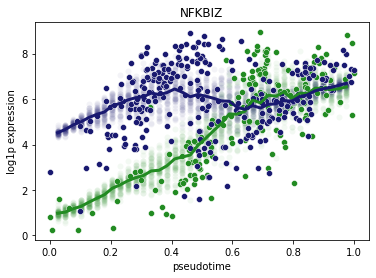

In [6]:
# plot the interpolated pair of reference and query trajectories for the gene
# NOTE: the bold points are real cells, whereas faded points represent interpolated (imputed) cells 
al_obj.plotTimeSeries(aligner, plot_cells=True, plot_mean_trend=True)

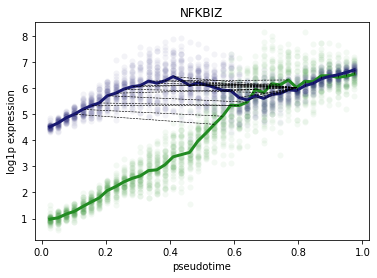

In [158]:
# show aligned/connected time points 
al_obj.plotTimeSeriesAlignment()

We can visualise the alignment as follows. Top line of stars represent time points in the reference. Bottom line of stars represent time points in the query. Matched points are highlighted in green. Mismatched points are highlighted in red. The symbol ^ refers to a warp (1-to-many or many-to-1 matched following a match). 

In [157]:
# visualise the alignment
al_obj.print_alignment() 
# or print(al_obj.al_visual)

#We can quantify the alignment using the optimal alignment cost measured in nits
print('optimal alignment cost = ' , al_obj.fwd_DP.opt_cost, 'nits') 

0123456789012345678901234567890123456789012345678901234567 Alignment index 
   0123456789012345678901234567890000000000000000001234567 Reference index
---*******************************^^^^^^^^^^^^^^^^^*******
***--------------------***********************************
012                    34567890123456789012345678901234567 Query index
IIIDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMVVVVVVVVVVVVVVVVVMMMMMMM 5-state string 
Matched percentages: 
w.r.t alignment:  60.34 %
w.r.t ref:  47.37 %
w.r.t query:  92.11 %
optimal alignment cost =  57.33820659952138 nits


In [159]:
# get the match percentage between ref and query, in terms of (1) the alignment, (2) w.r.t ref and (3) w.r.t query
al_obj.get_series_match_percentage() 

(60.34, 47.37, 92.11)

#### 1.3 Visualise the optimal alignment cost landscape and highlight the alignment path through it

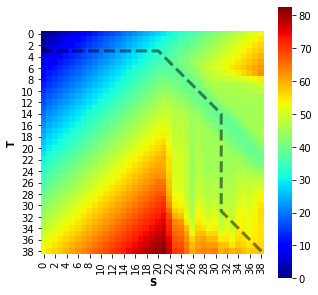

In [7]:
al_obj.landscape_obj.plot_alignment_landscape() 

Below visualises the pairwise Delta (alignment score) matrix where each cell gives the Genes2Genes distance measure between each pair of reference timepoint and query timepoint. 

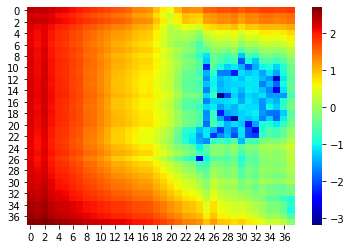

In [8]:
aligner.show_pairwise_distance_matrix(al_obj)

#### 1.2 Check the Differential Expression statistics for the matched points for sanity checking 

You can also plot the gene expression distributions between the matched points to sanity check. 
We expect no significant differential expression in between matched timepoints. 
<br>
The below table gives 
<ul>
<li>Which timepoints are matched (noth bin indices and pseudotime indices)<\li>
<li>The Genes2Genes statistic (Delta) which plays a similar role to the p-value<\li>
<li>The log2fold change (l2fc)<\li>
<li>P-value from wilcoxon rank-sum test<\li>
<li>P-value from KS2 test<\li>
<li>P-value from ttest<\li>
<\ul>


,ref_bin,query_bin,ref_pseudotime,query_pseudotime,Delta,l2fc,wilcox,ks2,ttest
0,20.0,3.0,0.538462,0.102564,1.585307,-0.116844,0.000038,0.000000,0.000008
1,21.0,4.0,0.564103,0.128205,1.246329,-0.074242,0.023593,0.000002,0.027231
2,22.0,5.0,0.589744,0.153846,1.239114,0.005090,0.813041,0.039195,0.890534
3,23.0,6.0,0.615385,0.179487,0.523123,-0.026213,0.533523,0.011512,0.433391
4,24.0,7.0,0.641026,0.205128,0.280444,-0.064017,0.046217,0.005842,0.021164
5,25.0,8.0,0.666667,0.230769,0.073328,0.035994,0.160155,0.021708,0.203677
6,26.0,9.0,0.692308,0.256410,0.420433,-0.032393,0.346605,0.005842,0.389259
7,27.0,10.0,0.717949,0.282051,0.116839,0.025103,0.612297,0.271914,0.436374
8,28.0,11.0,0.743590,0.307692,-0.018439,0.006940,0.625911,0.395940,0.826904
9,29.0,12.0,0.769231,0.333333,-0.073550,0.009891,0.768433,0.869262,0.758487


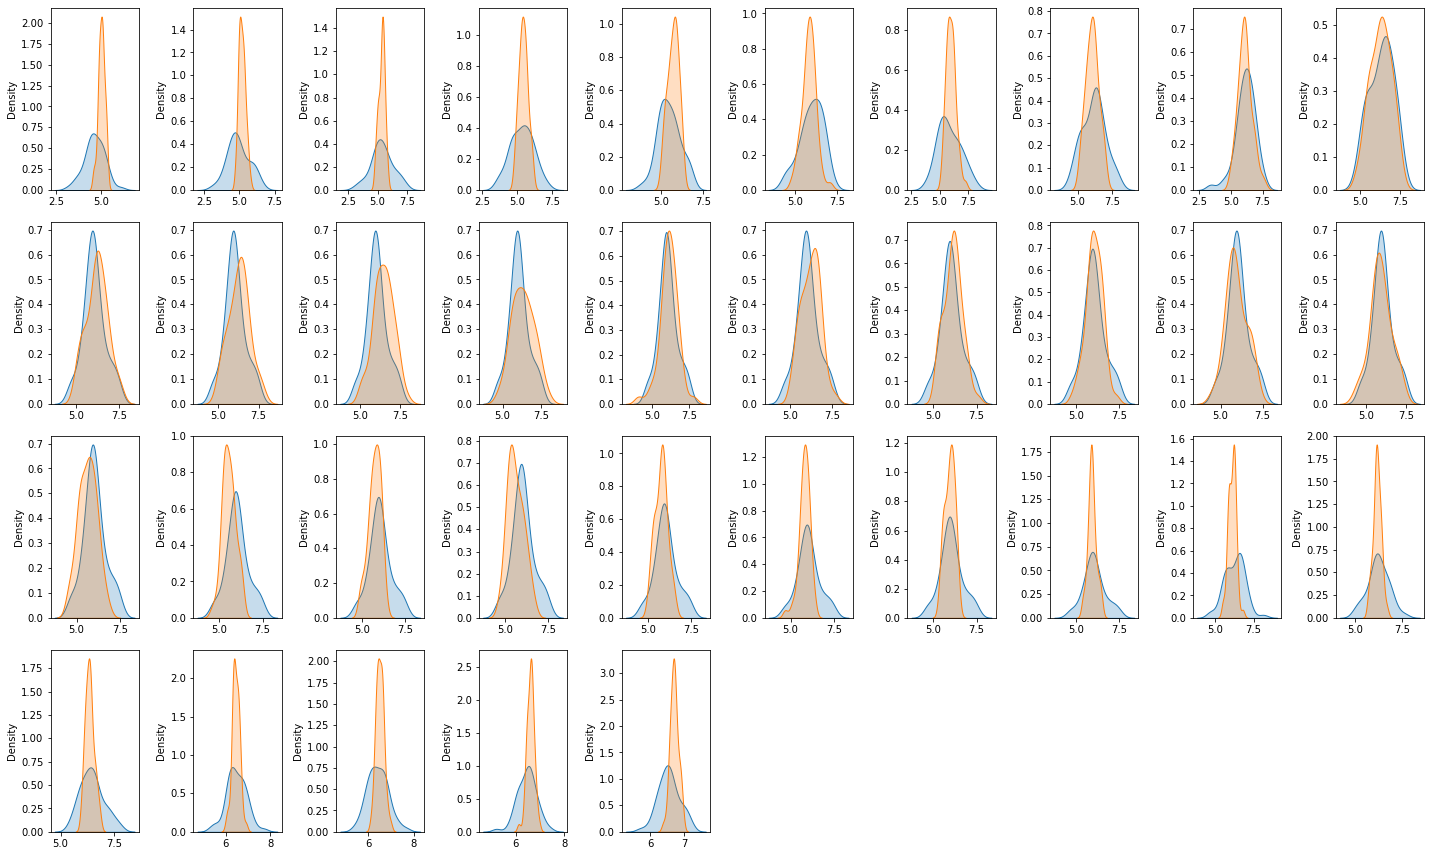

In [12]:
al_obj.plot_matched_region_dists()
al_obj.matched_region_DE_info

We can also examine the Pearson correlation coefficient trend along the pseudotime between ref and query <br>
(Note: this only gives us information about similarity in the trend of expression, not actual expression level differences).

<AxesSubplot:>

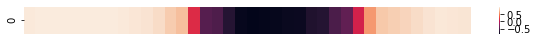

In [13]:
cc_trend = aligner.get_correlation_coefficient_trend(gene)
df = pd.DataFrame([cc_trend])
plt.subplots(1,1,figsize=(10,0.5)) #sharex, sharey
plt.subplot(1,1,1)
sb.heatmap(df, xticklabels=[]) 

### 2. Generate pairwise alignments between reference and query for a gene list

Run below to create an aligner, interpolate all reference and query gene trajectories, and generate pairwise alignment for each gene.

In [4]:
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, 40)
aligner.WEIGHT_BY_CELL_DENSITY = True
aligner.interpolate_genes() 
aligner.align_all_pairs()

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

Overall alignment considering alignment matches and mismatches across all the tested genes

DDDDDDDDMMMMMMMMMMMMMMMMMMMMMMMIIIIIIIIMMMMMMM


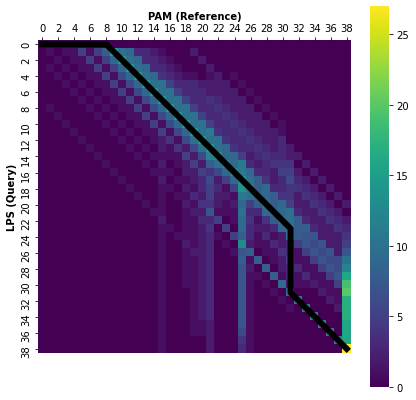

In [5]:
import VisualUtils
overall_alignment, alignment_path = aligner.compute_overall_alignment()
mat = aligner.get_pairwise_match_count_mat()
print(overall_alignment)
VisualUtils.VisualUtils.plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat)

Check the trajectory alignment of a certain gene (e.g. ARG2)

0123456789012345678901234567890123456789012345 Alignment index 
0123456789012345678901234567890123456777777777 Reference index
**************************************^^^^^^^^
--------**************************************
        01234567890123456789012345678901234567 Query index
DDDDDDDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMVVVVVVVV 5-state string 
Matched percentages: 
w.r.t alignment:  82.61 %
w.r.t ref:  78.95 %
w.r.t query:  100.0 %


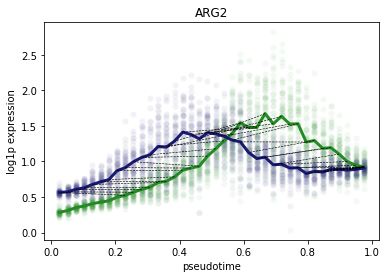

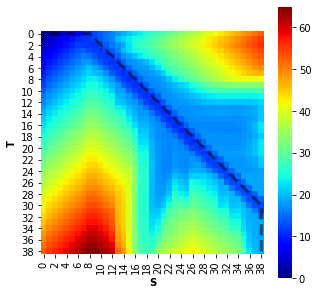

In [9]:
# access an alignment object for a particular gene and check its alignment | e.g. aligner.results_map['ARG2']
gene = 'ARG2'
aligner.results_map[gene].plotTimeSeriesAlignment() 
aligner.results_map[gene].alignment_str
aligner.results_map[gene].print_alignment() 
aligner.results_map[gene].landscape_obj.plot_alignment_landscape() 
# for sanity checking ---------- 
#aligner.results_map[gene].plot_matched_region_dists()
#aligner.results_map[gene].matched_region_DE_info

### 2.1 Cluster alignments 
We can cluster the alignment strings to identify groups of genes that behave similarly along the pseudotime axis. Here we use hierarchical clustering scheme with a pairwise alignment distance matrix computed based on the 3 different characteristics of the 5-state strings. A cluster will have a group of genes that show similar trend and expression level matches/mismatches over the pseudotime axis.

 24%|██▎       | 21/89 [00:00<00:00, 102.49it/s]

computing the Distance matrix


100%|██████████| 89/89 [00:00<00:00, 104.45it/s]


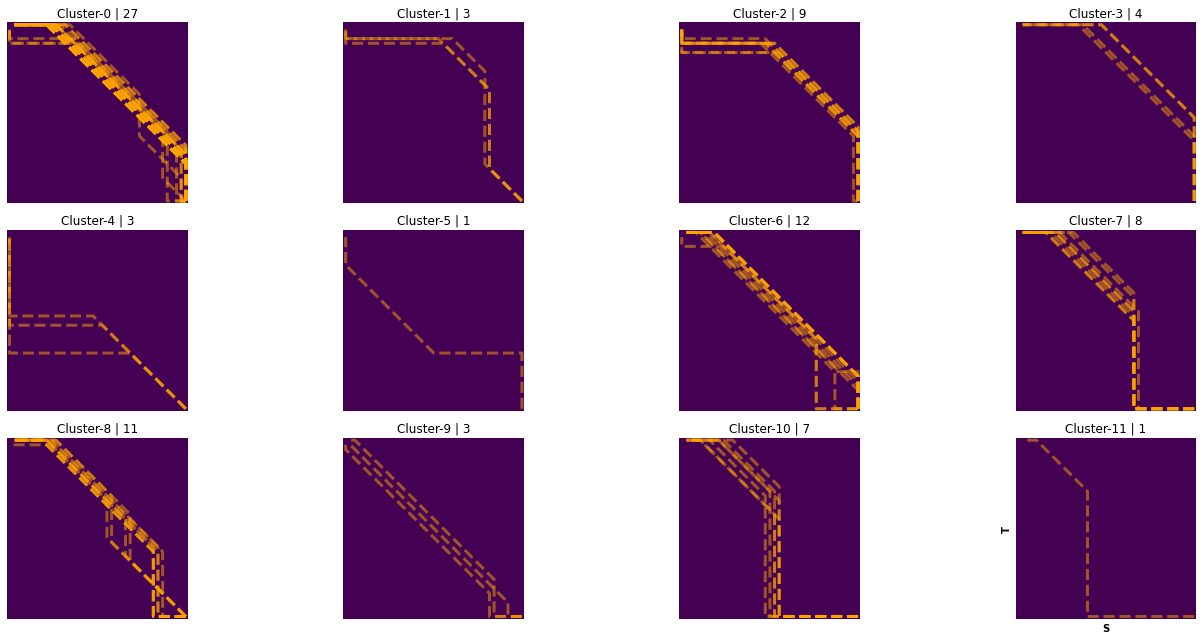

In [10]:
# You can either specify the number of clusters or a distance threshold to be used. 
aligner.cluster_all_alignments(n_clusters=None, possible_dist_threshold=120)
#aligner.cluster_all_alignments(n_clusters=None, possible_dist_threshold=50)
#aligner.cluster_all_alignments(n_clusters=25)

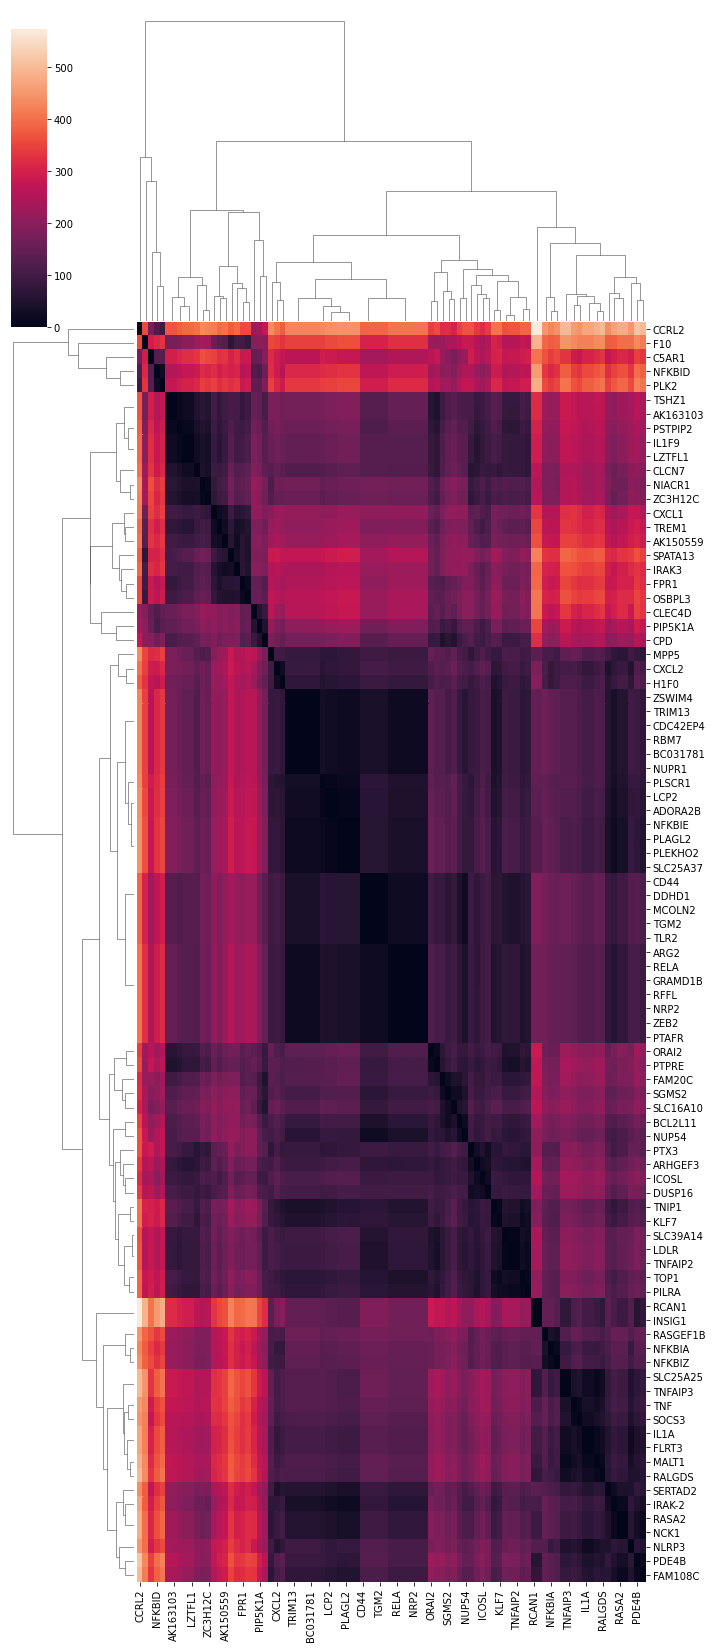

In [11]:
# check the pairwise alignment distance matrix
sb.clustermap(aligner.DistMat, figsize=(10,23))

In [12]:
for cluster_id in range(len(aligner.gene_clusters)):
    print(cluster_id, '------------------------------------------------------------')
    #aligner.show_cluster_alignment_strings(cluster_id)
    #if(len(aligner.gene_clusters[cluster_id])==1):
    print(cluster_id, len(aligner.gene_clusters[cluster_id]), aligner.gene_clusters[cluster_id])
    
#aligner.results_map['F10'].plotTimeSeriesAlignment()
#aligner.results_map['F10'].plotTimeSeries(aligner, plot_cells=True)
#aligner.results_map['F10'].plotTimeSeriesAlignment()
#aligner.results_map['F10'].print_alignment()
#aligner.results_map['C5AR1'].plotTimeSeries(aligner, plot_cells=True)
#aligner.results_map['C5AR1'].plotTimeSeriesAlignment()
#aligner.results_map['C5AR1'].print_alignment()

0 ------------------------------------------------------------
0 27 ['ADORA2B', 'ARG2', 'BC031781', 'CDC42EP4', 'CXCL2', 'GRAMD1B', 'H1F0', 'IRAK-2', 'LCP2', 'MPP5', 'NCK1', 'NFKBIE', 'NRP2', 'NUPR1', 'PLAGL2', 'PLEKHO2', 'PLSCR1', 'PTAFR', 'RASA2', 'RBM7', 'RELA', 'RFFL', 'SERTAD2', 'SLC25A37', 'TRIM13', 'ZEB2', 'ZSWIM4']
1 ------------------------------------------------------------
1 3 ['NFKBIA', 'NFKBIZ', 'RASGEF1B']
2 ------------------------------------------------------------
2 9 ['FLRT3', 'IL1A', 'MALT1', 'NLRP3', 'RALGDS', 'SLC25A25', 'SOCS3', 'TNF', 'TNFAIP3']
3 ------------------------------------------------------------
3 4 ['FAM108C', 'INSIG1', 'PDE4B', 'RCAN1']
4 ------------------------------------------------------------
4 3 ['CCRL2', 'NFKBID', 'PLK2']
5 ------------------------------------------------------------
5 1 ['C5AR1']
6 ------------------------------------------------------------
6 12 ['BCL2L11', 'CD44', 'DDHD1', 'FAM20C', 'MCOLN2', 'NUP54', 'ORAI2', 'PTPRE', 

IIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMMMMM
IIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMM
IIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMMM


['CCRL2', 'NFKBID', 'PLK2']

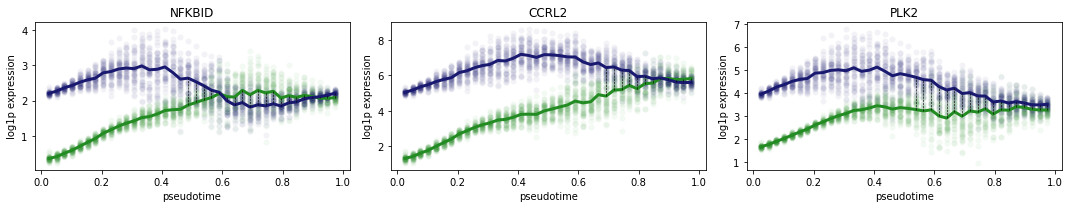

In [8]:
# to access cluster ids of all alignment objects
aligner.cluster_ids

cluster_id = 10 # for DEMO 
cluster_id = 4 # local 
#cluster_id = 2 # global 

aligner.gene_clusters[cluster_id]

# to plot the gene alignments in a cluster
aligner.show_cluster_plots(cluster_id, show_alignment=True)

# to print the alignments strings in a cluster
aligner.show_cluster_alignment_strings(cluster_id)

# to get the list of genes belonging to the cluster
aligner.gene_clusters[cluster_id]

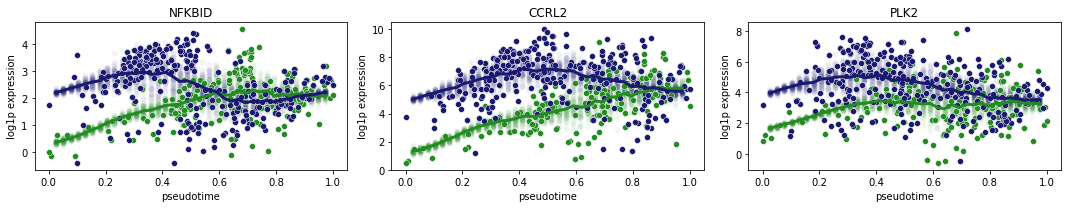

In [14]:
aligner.show_cluster_plots(cluster_id, show_alignment=False)

We can also order the genes based on their alignments by ordering them in their first match between reference and query along the pseudotime. This shows us which genes first started to match between the 2 systems, and may give a cascading order in matches along the pseudotime if there exists any.

In [18]:
ordered_gene_list = aligner.show_ordered_alignments()

Gene      Alignment
--------  ------------------------------------------------------------------
PIP5K1A   MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMIIIDDD
CLEC4D    IIMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMIIIIIDDDDDDD
CPD       DDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMIIIIIIIIDDDDDD
SLC16A10  DDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMDDDDDIIIIIIII
F10       DDDDMMMMMMMMMMMVVVVVVVVVVVVVVVVVVVVVVVVVVVDDDDDDDDDDDDDDDDDDDDDDD
OSBPL3    DDDDMMMMMMMMMMMMMMMMVVVVVVVVVVVVVVVVVVVVIIDDDDDDDDDDDDDDDDDD
FPR1      DDDDMMMMMMMMMMMMMMMMMVVVVVVVVVVVVVVVVVIIIIDDDDDDDDDDDDDDDDD
SGMS2     DDDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMIIII
FAM20C    DDDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMIIIIIIIIIDDDDD
BCL2L11   DDDDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMIIIII
NUP54     DDDDDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMVVVVVV
AK163103  DDDDDDMMMMMMMMMMMMMMMMMMMVVVVVVVVVVVVVVVVVVVDDDDDDDDDDDDD
TSHZ1     DDDDDDMMMMMMMMMMMMMMMMMMMVVVVVVVVVVVVVVVVVIIDDDDDDDDDDDDD
SPATA13   DDDDDDMMMMMMMMMMMMVVVVVVVVVVVVVVVVVVIIIIIIIIDDDDDDDDDDDDDDDDDDDD
PTPRE     DDDDDDMMMMMMMMMMMMMMMMM

#### 2.2 Quantitative measure for the similarity between the reference and query 
We can report the similarity between reference and query systems in terms of the average match proportion in their pairwise gene alignments. 

mean matched percentage:  59.12 %
mean matched percentage wrt ref:  61.86 %
mean matched percentage wrt query:  80.1 %


,match %,match % S,match % T,cluster_id
0,57.14,52.63,84.21,3.0
1,57.63,44.74,89.47,10.0
2,64.41,44.74,100.00,7.0
3,28.81,44.74,44.74,2.0
4,79.17,73.68,100.00,0.0
...,...,...,...,...
84,46.88,31.58,78.95,10.0
85,80.85,76.32,100.00,0.0
86,58.33,73.68,73.68,0.0
87,43.40,60.53,60.53,8.0


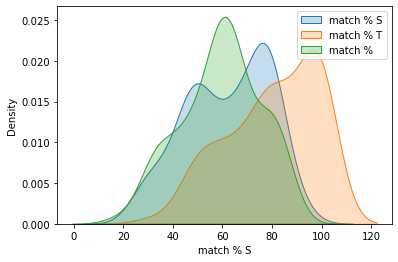

In [13]:
df = aligner.get_match_stat_for_all_genes() 
print('mean matched percentage: ', round(np.mean(df['match %']),2),'%' )
print('mean matched percentage wrt ref: ',round(np.mean(df['match % S']),2),'%'  )
print('mean matched percentage wrt query: ', round(np.mean(df['match % T']),2),'%' )
# average matched percentage by alignment cluster
df.groupby('cluster_id').mean()
sb.kdeplot(df['match % S'], fill=True, label='match % S')
sb.kdeplot(df['match % T'], fill=True,label='match % T')
sb.kdeplot(df['match %'], fill=True,label='match %')
plt.legend()
df

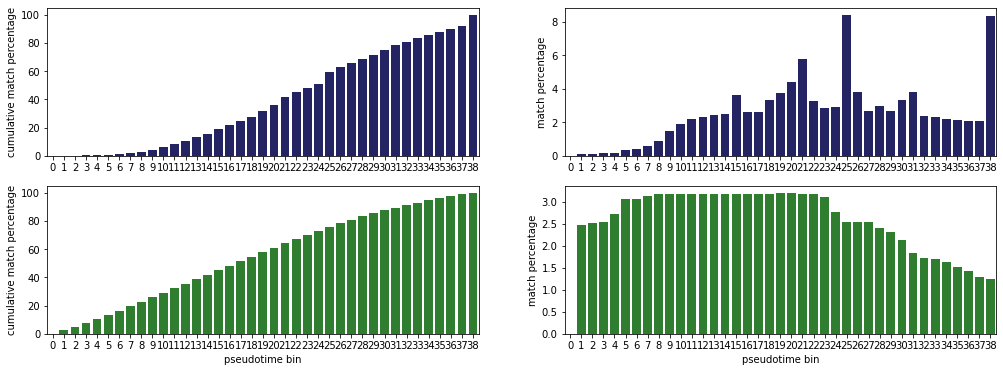

In [17]:
vs = VisualUtils.VisualUtils(adata_ref, adata_query, cell_type_colname = '', 
                 S_len=len(aligner.results[0].S.time_points), T_len=len(aligner.results[0].T.time_points), titleS='PAM', titleT='LPS', mode='simple')
vs.plot_match_stat_across_all_alignments(aligner)

In [27]:
#aligner.results_map['TLR2'].print_alignment()
#aligner.results_map['TLR2'].plotTimeSeriesAlignment()

#### 2.3 Differentially Expressed (DE) genes along the pseudotime 

A ranked list of genes based on their alignment percentage can be used to identify differentially expressed genes along the pseudotime.

Accordingly the top 10 DE genes between the PAM and LPS system we find under Genes2Genes are:
**CCRL2, TNF, SLC25A25, TNFAIP3, PLK2, MALT1, CXCL2, C5AR1, RALGDS, INSIG1**

In [19]:
x = PathwayAnalyser.PathwayEnrichmentAnalyser(aligner).make_ranked_genelist() 
x = pd.DataFrame(x)
#sb.displot(pd.DataFrame(x)[1]); plt.show()

In [20]:
x[0:10]

,0,1
0,CCRL2,0.1875
1,TNF,0.2881
2,SLC25A25,0.3103
3,TNFAIP3,0.3103
4,PLK2,0.3103
5,MALT1,0.3333
6,CXCL2,0.3333
7,C5AR1,0.3333
8,RALGDS,0.3571
9,INSIG1,0.3571


#### 2.4 Overrepresentation analysis using the hypergeometric test to identify which pathways the DE genes are most involved in  
Using g:Profiler wrapper in scanpy that also uses the standard hypergeometric test with same FDR correction 

##### 2.4.1 Overrepresentation analysis of each cluster

In [21]:
pathMan = PathwayAnalyser.PathwayEnrichmentAnalyser(aligner)
pathMan.run_cluster_enrichment() # runs g:profiler and outputs only the clusters with significance hits for overrepresentation

100%|██████████| 12/12 [00:33<00:00,  2.83s/it]

+----+--------------+-----------+--------------------------------+----------------------------------------------------+-------------------------------------------------+
|    |   cluster_id |   n_genes | geneset                        | KEGG_pathways                                      | REACTOME_pathways                               |
+====+==============+===========+================================+====================================================+=================================================+
|  0 |            0 |        27 | ['ARG2', 'BC031781',           | ['T cell receptor signaling pathway' 'Amoebiasis'] | []                                              |
|    |              |           | 'CDC42EP4', 'CXCL2',           |                                                    |                                                 |
|    |              |           | 'GRAMD1B', 'H1F0', ' ... ',    |                                                    |                               

In [22]:
pathMan.get_cluster_table(write_file=False)

run MVG alignment


  0%|          | 0/12 [00:00<?, ?it/s]

+----+-----------+-----------+--------------------------+---------------------------+---------------------------+-------------------------------------------------------------------+-------+-------+--------+
|    |   cluster |   n_genes | geneset                  | KEGG_pathways             | REACTOME_pathways         | cell-level alignment                                              |    A% |    S% |     T% |
+====+===========+===========+==========================+===========================+===========================+===================================================================+=======+=======+========+
|  0 |         0 |        27 | ['ARG2', 'BC031781',     | ['T cell receptor         | []                        | 012345678901234567890123456789012345678901234567                  | 58.33 | 73.68 |  73.68 |
|    |           |           | 'CDC42EP4', 'CXCL2',     | signaling pathway'        |                           | 01234567890123456789012345678901234567                    

In [23]:
aligner.show_cluster_table()

+----+--------------+-----------+--------------------------------+--------+--------+--------+--------------------------------------------------------------------------------+
|    |   cluster_id |   n_genes | gene_set                       |     A% |     S% |     T% | cell-level alignment                                                           |
+====+==============+===========+================================+========+========+========+================================================================================+
|  0 |            0 |        27 | ['ARG2', 'BC031781',           |  58.33 |  73.68 |  73.68 | 012345678901234567890123456789012345678901234567                               |
|    |              |           | 'CDC42EP4', 'CXCL2',           |        |        |        | 01234567890123456789012345678901234567                                         |
|    |              |           | 'GRAMD1B', 'H1F0', ' ... ',    |        |        |        | *******************************

##### 2.4.1 Overrepresentation analysis of top (<50% aligned) DE genes

In [24]:
gprofiler_results = pathMan.run_gprofiler() # run overepresentation analysis on top DE genes -- below 50% alignment by default

24  # of DE genes to check


In [25]:
gprofiler_results[gprofiler_results.source=='KEGG']

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
10,KEGG,KEGG:04064,NF-kappa B signaling pathway,0.000904,True,NF-kappa B signaling pathway,102,13,4,8064,0.307692,0.039216,query_1,[KEGG:00000]
34,KEGG,KEGG:04621,NOD-like receptor signaling pathway,0.008571,True,NOD-like receptor signaling pathway,181,13,4,8064,0.307692,0.022099,query_1,[KEGG:00000]
47,KEGG,KEGG:05417,Lipid and atherosclerosis,0.016339,True,Lipid and atherosclerosis,214,13,4,8064,0.307692,0.018692,query_1,[KEGG:00000]
53,KEGG,KEGG:04657,IL-17 signaling pathway,0.021646,True,IL-17 signaling pathway,92,13,3,8064,0.230769,0.032609,query_1,[KEGG:00000]
56,KEGG,KEGG:05131,Shigellosis,0.027817,True,Shigellosis,246,13,4,8064,0.307692,0.016260,query_1,[KEGG:00000]
58,KEGG,KEGG:04625,C-type lectin receptor signaling pathway,0.031039,True,C-type lectin receptor signaling pathway,104,13,3,8064,0.230769,0.028846,query_1,[KEGG:00000]
61,KEGG,KEGG:04668,TNF signaling pathway,0.038558,True,TNF signaling pathway,112,13,3,8064,0.230769,0.026786,query_1,[KEGG:00000]


In [26]:
gprofiler_results[gprofiler_results.source=='REAC']

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
63,REAC,REAC:R-HSA-5357786,TNFR1-induced proapoptotic signaling,0.042872,True,TNFR1-induced proapoptotic signaling,13,15,2,10461,0.133333,0.153846,query_1,[REAC:R-HSA-75893]


In [44]:
gprofiler_results_kegg = gprofiler_results[gprofiler_results.source == 'KEGG']
gprofiler_results_gobp = gprofiler_results[gprofiler_results.source == 'GO:BP']
gprofiler_results_reac = gprofiler_results[gprofiler_results.source == 'REAC']

temp_kegg = pd.DataFrame([gprofiler_results_kegg.name, -np.log10(gprofiler_results_kegg['p_value'])    ]).transpose()
temp_kegg.columns = ['KEGG Pathway','-log10(p_value)']
temp_gobp= pd.DataFrame([gprofiler_results_gobp.name, -np.log10(gprofiler_results_gobp['p_value'])    ]).transpose()
temp_gobp.columns = ['GOBP Pathway','-log10(p_value)']
temp_reac= pd.DataFrame([gprofiler_results_reac.name, -np.log10(gprofiler_results_reac['p_value'])    ]).transpose()
temp_reac.columns = ['REACTOME Pathway','-log10(p_value)']

<AxesSubplot:xlabel='-log10(p_value)', ylabel='KEGG Pathway'>

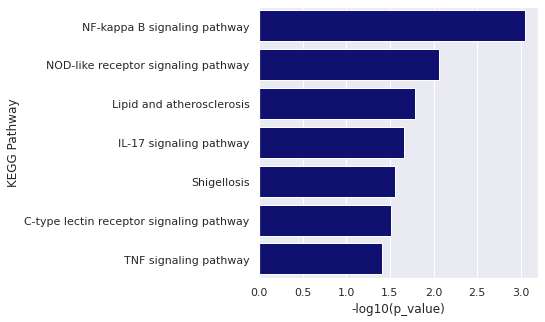

In [45]:
sb.set(rc={'figure.figsize':(5,5)})
sb.barplot(data=temp_kegg, x='-log10(p_value)',y='KEGG Pathway', color='navy')

<AxesSubplot:xlabel='-log10(p_value)', ylabel='GOBP Pathway'>

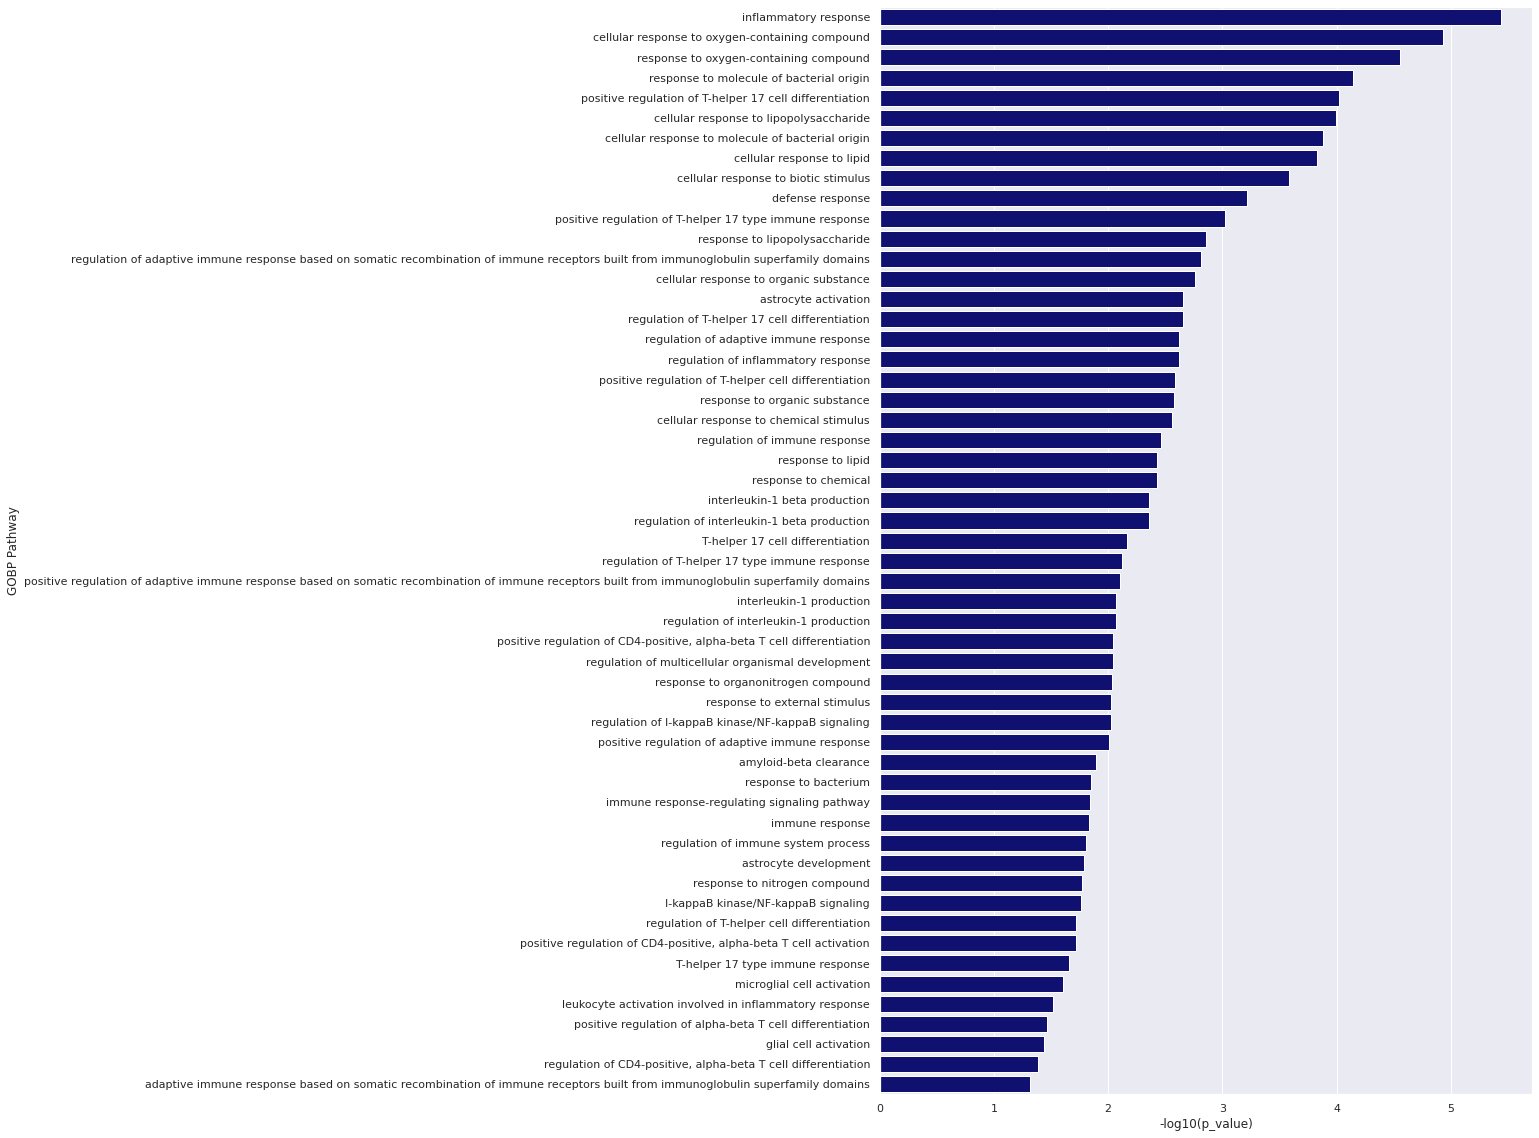

In [46]:
sb.set(rc={'figure.figsize':(11.7,20)})
sb.barplot(data=temp_gobp, x='-log10(p_value)',y='GOBP Pathway', color='navy')
#plt.savefig('Figures/PAM_LPS_enrichment_analysis_GOBP_barplot.png', bbox_inches = 'tight')

<AxesSubplot:xlabel='-log10(p_value)', ylabel='REACTOME Pathway'>

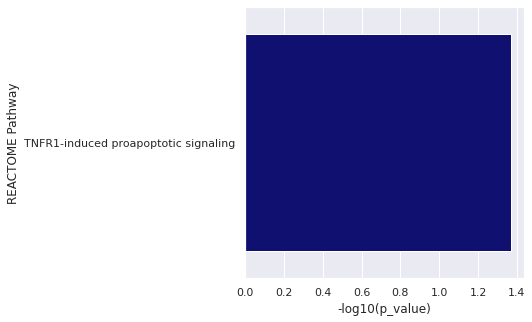

In [47]:
sb.set(rc={'figure.figsize':(5,5)})
sb.barplot(data=temp_reac, x='-log10(p_value)',y='REACTOME Pathway', color='navy')

#####  2.4.3 GSEA on the ranked list of genes based on alignment % 

In [29]:
temp = pd.DataFrame(x)
temp = temp.set_index(0)

In [30]:
temp = pd.DataFrame(x)
temp = temp.set_index(0)
import gseapy as gp
import blitzgsea as blitz
targets1 = blitz.enrichr.get_library("KEGG_2021_Human")
targets2 = blitz.enrichr.get_library("GO_Biological_Process_2021") 
targets3 = blitz.enrichr.get_library("Reactome_2022") 
targets4 = blitz.enrichr.get_library("BioCarta_2016")  

In [31]:

pre_res = gp.prerank(rnk=temp, # or rnk = rnk,
                     gene_sets=targets1,
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2022-11-09 19:07:28,254 Parsing data files for GSEA.............................
2022-11-09 19:07:28,260 0292 gene_sets have been filtered out when max_size=1000 and min_size=5
2022-11-09 19:07:28,260 0028 gene_sets used for further statistical testing.....
2022-11-09 19:07:28,261 Start to run GSEA...Might take a while..................
2022-11-09 19:07:28,304 Congratulations. GSEApy runs successfully................



In [32]:
pre_res.res2d.head(5)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,EPSTEIN-BARR VIRUS INFECTION,0.549713,1.635558,0.030986,0.508723,0.202,5/8,25.84%,CD44;RELA;NFKBIE;BCL2L11;TLR2
1,prerank,MAPK SIGNALING PATHWAY,0.572495,1.469121,0.088191,0.62971,0.401,3/5,20.22%,RELA;DUSP16;RASA2
2,prerank,TNF SIGNALING PATHWAY,-0.394322,-1.247672,0.185714,1.0,0.485948,6/7,41.57%,TNF;TNFAIP3;CXCL2;SOCS3;NFKBIA;CXCL1
3,prerank,OSTEOCLAST DIFFERENTIATION,-0.410499,-1.239525,0.174194,1.0,0.491803,5/6,38.20%,TNF;IL1A;LCP2;SOCS3;NFKBIA
4,prerank,NF-KAPPA B SIGNALING PATHWAY,-0.378087,-1.206849,0.218121,0.862509,0.533958,6/7,41.57%,TNF;TNFAIP3;MALT1;CXCL2;NFKBIA;CXCL1


In [33]:
from gseapy import dotplot, ringplot
# to save your figure, make sure that ``ofname`` is not None
ax = ringplot(pre_res.res2d,
             column="FDR q-val",
             title='KEGG_2016',
             cmap=plt.cm.viridis,
             size=10, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=True)

In [34]:
pre_res = gp.prerank(rnk=temp, # or rnk = rnk,
                     gene_sets=targets2,
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )
pre_res.res2d.head(5)

2022-11-09 19:07:41,120 Parsing data files for GSEA.............................
2022-11-09 19:07:41,147 5987 gene_sets have been filtered out when max_size=1000 and min_size=5
2022-11-09 19:07:41,148 0049 gene_sets used for further statistical testing.....
2022-11-09 19:07:41,149 Start to run GSEA...Might take a while..................
2022-11-09 19:07:41,207 Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,INNATE IMMUNE RESPONSE (GO:0045087),0.570744,1.638764,0.040288,1.0,0.419,5/7,26.97%,RELA;TRIM13;PTX3;TLR2;CLEC4D
1,prerank,POSITIVE REGULATION OF PROTEIN METABOLIC PROCE...,-0.583333,-1.589502,0.046205,0.699052,0.334008,5/5,46.07%,TNF;TNFAIP3;PLK2;NFKBIA;SLC25A37
2,prerank,REGULATION OF INTRACELLULAR SIGNAL TRANSDUCTIO...,0.565374,1.51661,0.056851,1.0,0.626,3/6,8.99%,PIP5K1A;ARHGEF3;RELA
3,prerank,POSITIVE REGULATION OF CELLULAR PROCESS (GO:00...,0.540044,1.44232,0.084919,0.994583,0.748,4/6,25.84%,RELA;TRIM13;TGM2;TLR2
4,prerank,REGULATION OF APOPTOTIC PROCESS (GO:0042981),0.437007,1.417682,0.104139,0.852811,0.796,5/10,24.72%,CD44;ARHGEF3;RELA;BCL2L11;TGM2


In [35]:
pre_res = gp.prerank(rnk=temp, # or rnk = rnk,
                     gene_sets=targets3,
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )
pre_res.res2d.head(5)

2022-11-09 19:07:44,835 Parsing data files for GSEA.............................
2022-11-09 19:07:44,849 1789 gene_sets have been filtered out when max_size=1000 and min_size=5
2022-11-09 19:07:44,850 0029 gene_sets used for further statistical testing.....
2022-11-09 19:07:44,851 Start to run GSEA...Might take a while..................
2022-11-09 19:07:44,894 Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,PEPTIDE LIGAND-BINDING RECEPTORS R-HSA-375276,-0.626506,-1.886726,0.011194,0.097735,0.060143,6/6,42.70%,CCRL2;CXCL2;C5AR1;NLRP3;CXCL1;FPR1
1,prerank,METABOLISM R-HSA-1430728,0.558722,1.783011,0.022193,0.233111,0.164,5/10,10.11%,NUP54;PIP5K1A;CD44;ARG2;SGMS2
2,prerank,GPCR LIGAND BINDING R-HSA-500792,-0.446761,-1.551231,0.068826,0.180771,0.252803,7/8,42.70%,CCRL2;CXCL2;C5AR1;NLRP3;ADORA2B;CXCL1;FPR1
3,prerank,CLASS A/1 (RHODOPSIN-LIKE RECEPTORS) R-HSA-373076,-0.446761,-1.551231,0.068826,0.180771,0.252803,7/8,42.70%,CCRL2;CXCL2;C5AR1;NLRP3;ADORA2B;CXCL1;FPR1
4,prerank,DISEASE R-HSA-1643685,0.455518,1.486389,0.080272,0.72684,0.595,6/11,25.84%,NUP54;RELA;DUSP16;BCL2L11;NCK1;TLR2


In [36]:
pre_res = gp.prerank(rnk=temp, # or rnk = rnk,
                     gene_sets=targets4,
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )
pre_res.res2d.head(5)

2022-11-09 19:07:51,748 Parsing data files for GSEA.............................
2022-11-09 19:07:51,750 0236 gene_sets have been filtered out when max_size=1000 and min_size=5
2022-11-09 19:07:51,751 0001 gene_sets used for further statistical testing.....
2022-11-09 19:07:51,752 Start to run GSEA...Might take a while..................
2022-11-09 19:07:51,764 Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,SIGNAL TRANSDUCTION THROUGH IL1R HOMO SAPIENS ...,-0.351862,-0.933542,0.543046,0.543046,0.543046,4/5,38.20%,TNF;IL1A;IRAK3;NFKBIA


In [37]:
from gseapy import dotplot, ringplot
# to save your figure, make sure that ``ofname`` is not None
ringplot(pre_res.res2d,
             column="FDR q-val",
             title='KEGG_2021',
             cmap=plt.cm.viridis,
             size=10, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=True)

'Warning: No enrich terms when cutoff = 0.25'

## 3. Complementary analysis

#### 3.1 Complementary correlation trend analysis for the gene between ref and query

In addition to the above Genes2Genes analysis, we can also separately check the ref vs. query pearson correlation coefficient of their mean expression trends along the trajectories (This first does distributional interpolation with fixed number of time bins and uses a sliding window to compute the pearson correlation coefficient). 

  0%|          | 0/89 [00:00<?, ?it/s]

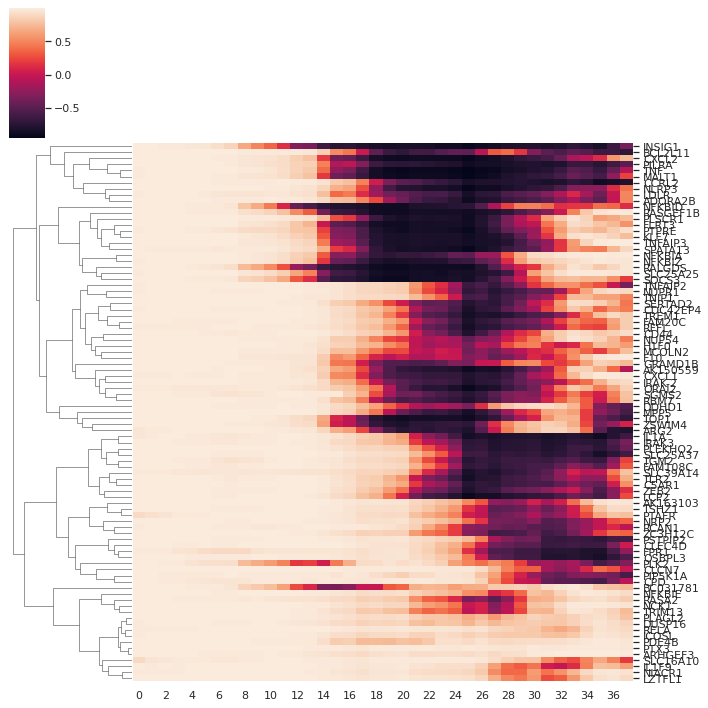

In [38]:
cc_df = aligner.get_correlation_coefficient_trend_for_all_genes()
cm = sb.clustermap(cc_df, col_cluster=False, yticklabels=True) 

#### 3.2 Check cell abundance along the pseudotime axis for each series 
Note: You will see the same plot for all genes becauses we have the same cells across all genes in each system


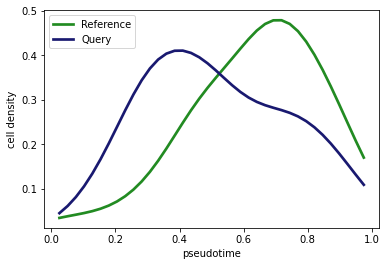

In [6]:
S = aligner.results_map['NFKBIZ'].get_ref_timeseries_obj()
T = aligner.results_map['NFKBIZ'].get_query_timeseries_obj()
sb.lineplot(S.time_points, S.cell_densities, color='forestgreen', linewidth=2.7, label='Reference')
sb.lineplot(T.time_points, T.cell_densities, color='midnightblue',linewidth=2.7, label='Query')
plt.xlabel('pseudotime')
plt.ylabel('cell density')
plt.legend()
plt.show()

#### 3.3 Plot z-normalised original vs interpolated gene expression heatmaps for reference vs. query 

Checking differences between ref and query with gene expression values alone 

In [40]:
aligner.prepare_interpolated_non_interpolated_mats()

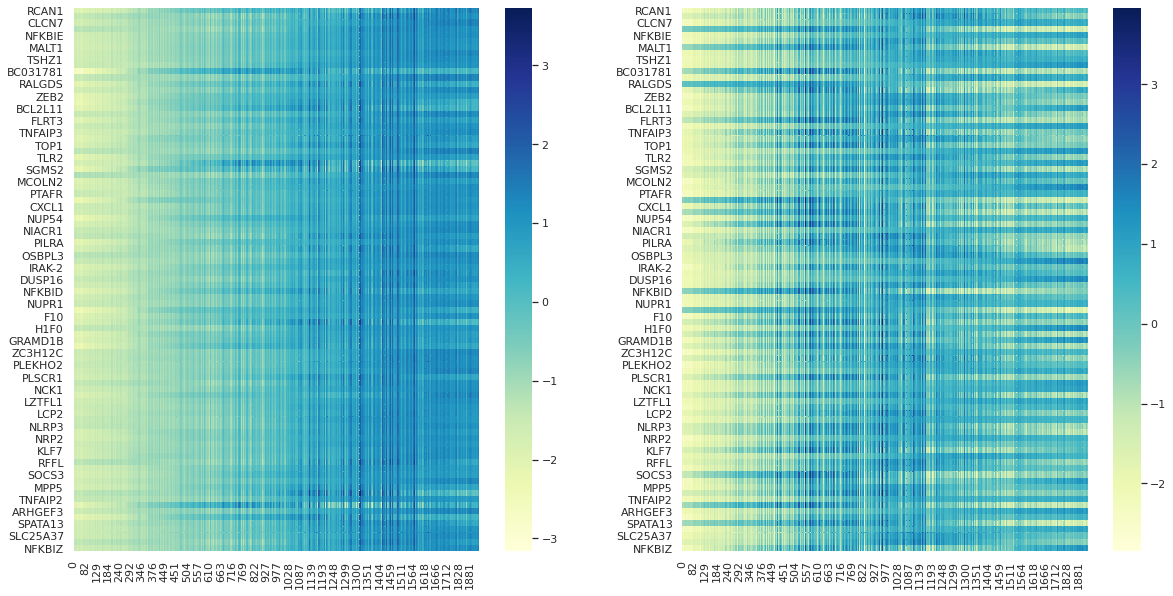

In [41]:
aligner.prepare_interpolated_non_interpolated_mats()
plt.subplots(1,2, figsize=(20,10))
plt.subplot(1,2,1)
sb.heatmap(aligner.ref_intpl_df.transpose(),cmap = 'YlGnBu',) 
plt.subplot(1,2,2)
sb.heatmap(aligner.query_intpl_df.transpose(),cmap = 'YlGnBu'  ) 
plt.show()

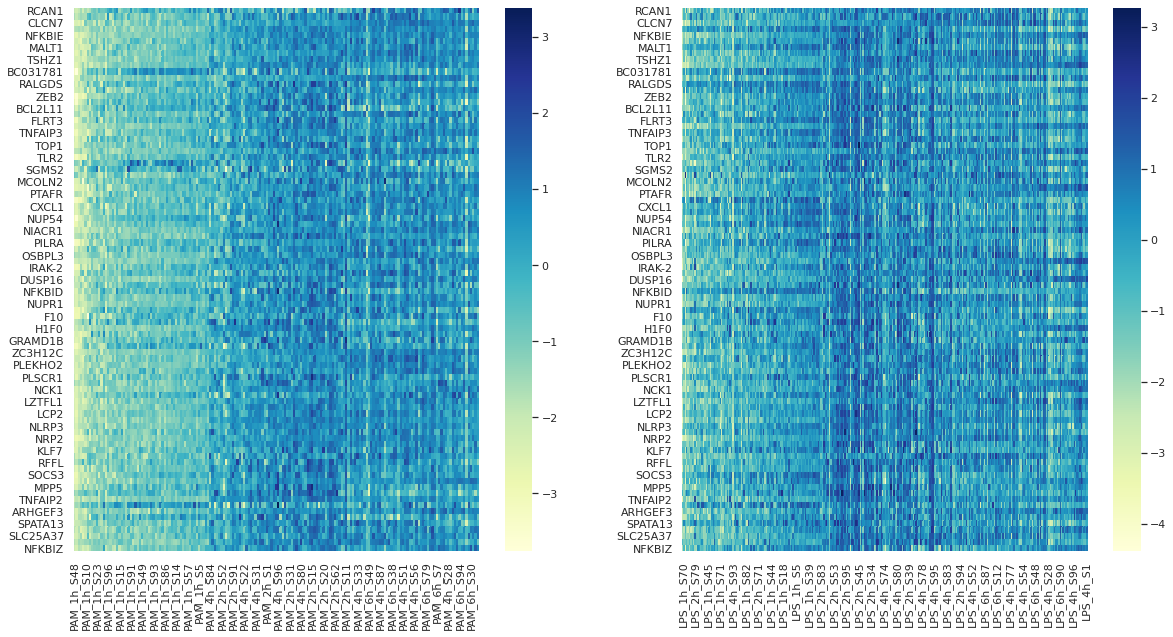

In [42]:
plt.subplots(1,2, figsize=(20,10))
plt.subplot(1,2,1)
sb.heatmap(aligner.ref_expr_df.transpose(),cmap = 'YlGnBu',) 
plt.subplot(1,2,2)
sb.heatmap(aligner.query_expr_df.transpose(),cmap = 'YlGnBu'  ) 
plt.show()

In [31]:
#sb.clustermap(aligner.ref_expr_df.transpose(), col_cluster=False,cmap = 'YlGnBu',figsize=(5,5)) 
#sb.clustermap(aligner.query_expr_df.transpose(), col_cluster=False,cmap = 'YlGnBu',figsize=(5,5)) 
#sb.clustermap(aligner.ref_intpl_df.transpose(), col_cluster=False,cmap = 'YlGnBu',figsize=(5,5)) 
#sb.clustermap(aligner.query_intpl_df.transpose(), col_cluster=False,cmap = 'YlGnBu',figsize=(5,5)) 
#plt.show()

#### 3.4 Visualising multiple alignment paths (Example)

We can also check a set of multiple alignments paths by visualising them

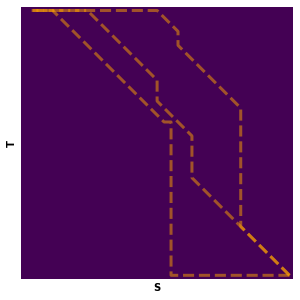

In [34]:
paths = [aligner.results_map['NFKBIZ'].landscape_obj.alignment_path,
         aligner.results_map['RELA'].landscape_obj.alignment_path,
         aligner.results_map['FPR1'].landscape_obj.alignment_path]  

fig, axs = plt.subplots(1,1, figsize=(5,5))
orgalign.Utils().plot_different_alignments(paths,aligner.results[0].fwd_DP.S_len, 
                                           aligner.results[0].fwd_DP.T_len, ax=axs )

## <span style="color:midnightblue"> Cell-level alignment </span> 

We can also perform a cell-level alignment to find a single average representation of alignment between reference and query based a set of genes. For this, we can run Genes2Genes in the **multivariate mode**. 
<br><br>
**Multivariate mode** has 2 options:
<ol>
<li>Multivariate Gaussian distribution based matching</li>
<li>Multivariate mean expression based matching (using KL-divergence)</li>
</ol>

**Note:** Option 2 is faster but less accurate. We also note that cell-level alignment is not informative and less accurate. If we have gene-level alignments, we can inform about overall cell-level alignment using the quantitative measures we introduced in the previous section.

### 1. Average alignment of gene-level alignment clusters 
We can compute average alignment for each cluster we got from gene level alignment from below. <br>
Pass argument <MVG_MODE_KL = True> if you want option 2 in the multivariate mode. 

In [24]:
aligner.compute_cluster_MVG_alignments(MVG_MODE_KL=False)

run MVG alignment


  0%|          | 0/12 [00:00<?, ?it/s]

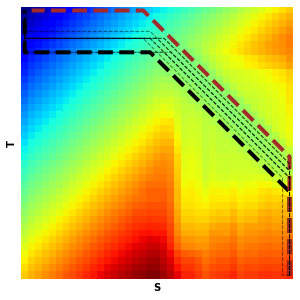

In [21]:
# plot the average alignment path (black highlighted path)
# of a cluster along with all alignments in the cluster (dashed paths)
aligner.plot_mvg_alignment(cluster_id=2)

# brown color highlighted dashed path is the average path in the alignment landscape
# black color highlighted dashed path is the MVG alignment path
# rest are the alignment paths in the cluster

# plot the average alignment optimal alignment cost landscape
#aligner.mvg_cluster_average_alignments[15].landscape_obj.plot_alignment_landscape()

In [20]:
# print the average alignment of the cluster
print(aligner.mvg_cluster_average_alignments[11].al_visual) 

01234567890123456789012345678901234567890123456789012345678901234 Alignment index 
01234567890123444444444444444444444444444456789012345678901234567 Reference index
***************^^^^^^^^^^^^^^^^^^^^^^^^^^^***********************
----**************************************-----------------------
    01234567890123456789012345678901234567                        Query index
DDDDMMMMMMMMMMMVVVVVVVVVVVVVVVVVVVVVVVVVVVDDDDDDDDDDDDDDDDDDDDDDD 5-state string 


In [22]:
len(aligner.mvg_cluster_average_alignments)

12

In [19]:
aligner.show_cluster_table()
#for cluster_id in range(len(aligner.mvg_cluster_average_alignments)):
#    aligner.mvg_cluster_average_alignments[cluster_id].print_alignment()
#    print('------------------------------------------------')

+----+--------------+-----------+--------------------------------+--------+--------+--------+--------------------------------------------------------------------------------+
|    |   cluster_id |   n_genes | gene_set                       |     A% |     S% |     T% | cell-level alignment                                                           |
+====+==============+===========+================================+========+========+========+================================================================================+
|  0 |            0 |        27 | ['ARG2', 'BC031781',           |  58.33 |  73.68 |  73.68 | 012345678901234567890123456789012345678901234567                               |
|    |              |           | 'CDC42EP4', 'CXCL2',           |        |        |        | 01234567890123456789012345678901234567                                         |
|    |              |           | 'GRAMD1B', 'H1F0', ' ... ',    |        |        |        | *******************************

In [25]:
#aligner.show_cluster_alignment_strings(10)

### 2. Get cell-level alignment for a given set of genes 

This could be an entire set of highly variable genes/transcription factors or an interested set of marker genes. Let us check the below example set for both modes (1) MVG alignment, and (2) KL-divergence distance based alignment

#### (1). MVG Alignment

In [42]:
gene_list = ['AK150559', 'KLF7', 'ORAI2', 'PILRA', 'SLC39A14', 'TNFAIP2', 'TNIP1', 'TREM1']
mvg_aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list,40)
mvg_aligner.WEIGHT_BY_CELL_DENSITY = True
mvg_aligner.interpolate_genes() 
avg_alignment = mvg_aligner.run_MVG_alignment(gene_list,MVG_MODE_KL=False)
avg_alignment.print_alignment()

  0%|          | 0/8 [00:00<?, ?it/s]

012345678901234567890123456789012345678901234567890123456789 Alignment index 
012345678901234567890111111111111111111111112345678901234567 Reference index
**********************^^^^^^^^^^^^^^^^^^^^^^****************
------**************************************----------------
      01234567890123456789012345678901234567                 Query index
DDDDDDMMMMMMMMMMMMMMMMVVVVVVVVVVVVVVVVVVVVVVDDDDDDDDDDDDDDDD 5-state string 
Matched percentages: 
w.r.t alignment:  63.33 %
w.r.t ref:  42.11 %
w.r.t query:  100.0 %


In [43]:
avg_alignment.alignment_str

'DDDDDDMMMMMMMMMMMMMMMMVVVVVVVVVVVVVVVVVVVVVVDDDDDDDDDDDDDDDD'

In [44]:
avg_alignment.print_alignment()

012345678901234567890123456789012345678901234567890123456789 Alignment index 
012345678901234567890111111111111111111111112345678901234567 Reference index
**********************^^^^^^^^^^^^^^^^^^^^^^****************
------**************************************----------------
      01234567890123456789012345678901234567                 Query index
DDDDDDMMMMMMMMMMMMMMMMVVVVVVVVVVVVVVVVVVVVVVDDDDDDDDDDDDDDDD 5-state string 
Matched percentages: 
w.r.t alignment:  63.33 %
w.r.t ref:  42.11 %
w.r.t query:  100.0 %


#### (2). KL-divergence based Alignment (faster but less accurate)

In [45]:
gene_list =['AK150559', 'KLF7', 'ORAI2', 'PILRA', 'SLC39A14', 'TNFAIP2', 'TNIP1', 'TREM1']
mvg_aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list,40)
mvg_aligner.WEIGHT_BY_CELL_DENSITY = True
mvg_aligner.interpolate_genes() 
avg_alignment = mvg_aligner.run_MVG_alignment(gene_list,MVG_MODE_KL=True)

  0%|          | 0/8 [00:00<?, ?it/s]

In [46]:
avg_alignment.alignment_str

'MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM'

### 3. An entire cell-level alignment

If we now run MVG mode for the entire gene set, we get no alignment at all. This is because different groups of genes starts matching in different ways at different time points, which confuses a cell-level alignment. 

In [47]:
import time
s_time = time.time()
gene_list = adata_ref.var_names
mvg_aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, 30)
mvg_aligner.WEIGHT_BY_CELL_DENSITY = True
mvg_aligner.interpolate_genes() 
avg_alignment = mvg_aligner.run_MVG_alignment(gene_list,MVG_MODE_KL=False)
e_time = time.time()
print('time taken: ', e_time-s_time)

  0%|          | 0/89 [00:00<?, ?it/s]

time taken:  11.643668413162231


In [48]:
avg_alignment.print_alignment() 

01234567890123456789012345678901234567890123456789012345 Alignment index 
                            0123456789012345678901234567 Reference index
----------------------------****************************
****************************----------------------------
0123456789012345678901234567                             Query index
IIIIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDDDDDD 5-state string 
Matched percentages: 
w.r.t alignment:  0.0 %
w.r.t ref:  0.0 %
w.r.t query:  0.0 %


In [49]:
avg_alignment.print_alignment() 

01234567890123456789012345678901234567890123456789012345 Alignment index 
                            0123456789012345678901234567 Reference index
----------------------------****************************
****************************----------------------------
0123456789012345678901234567                             Query index
IIIIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDDDDDD 5-state string 
Matched percentages: 
w.r.t alignment:  0.0 %
w.r.t ref:  0.0 %
w.r.t query:  0.0 %


### <span style="color:midnightblue"> Why MVG cell-level matching is more accurate than mean-based euclidean or KL divergence matching</span> 

In [54]:
mvg_list =['AK150559', 'KLF7', 'ORAI2', 'PILRA', 'SLC39A14', 'TNFAIP2', 'TNIP1', 'TREM1']
aligner = Main.RefQueryAligner(adata_ref, adata_query, mvg_list, 40)
aligner.WEIGHT_BY_CELL_DENSITY = True
mean_trends_S = np.repeat(0.0, 38)
mean_trends_T = np.repeat(0.0, 38)
x = []
for gene in mvg_list:
    a = aligner.align_single_pair(gene)
    x.append(a)
    mean_trends_S = mean_trends_S + a.fwd_DP.S.mean_trend
    mean_trends_T = mean_trends_T + a.fwd_DP.T.mean_trend
    
def plotTimeSeriesAlignment(a):  
    sb.lineplot(a.S.time_points, a.S.mean_trend, linewidth=3, color='forestgreen',alpha=0.3)
    sb.lineplot(a.T.time_points, a.T.mean_trend, linewidth=3, color='midnightblue',alpha=0.3)
    
    plt.xlabel('pseudotime')
    plt.ylabel('log1p expression')
    for i in range(a.matched_region_DE_info.shape[0]):
        S_timebin = int(a.matched_region_DE_info.iloc[i]['ref_bin'])
        T_timebin = int(a.matched_region_DE_info.iloc[i]['query_bin']) 
        x_vals = [a.matched_region_DE_info.iloc[i]['ref_pseudotime'],a.matched_region_DE_info.iloc[i]['query_pseudotime']] 
        y_vals = [a.S.mean_trend[S_timebin ], a.T.mean_trend[T_timebin]] 
        plt.plot(x_vals, y_vals, color='black', linestyle='dashed', linewidth=0.6)

Example of how average expression matchings differ from individual gene matchings between ref and query

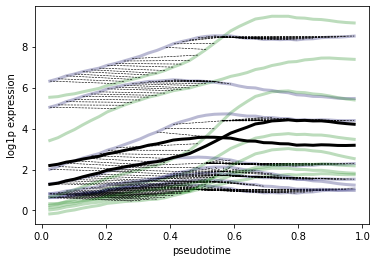

In [55]:
for a in x:
    plotTimeSeriesAlignment(a)
sb.lineplot(a.fwd_DP.S.time_points,mean_trends_S/len(mvg_list),color='black',linewidth=3)
sb.lineplot(a.fwd_DP.T.time_points,mean_trends_T/len(mvg_list),color='black',linewidth=3)
plt.show()